In [48]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [22]:
X, y = mnist["data"], mnist["target"]
X.shape
# There are 70,000 images, and each image has 784 features. because each image is 28×28 pixels
# each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black)

(70000, 784)

In [23]:
y.shape

(70000,)

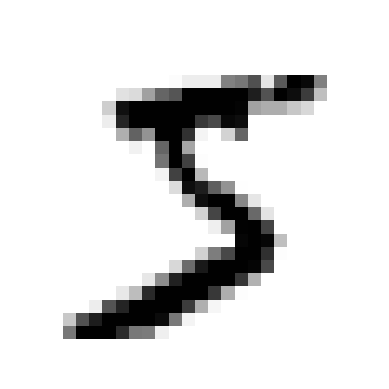

In [24]:
# To view a digit
#   - grab instance's feature vector and reshape it to 28*28 array
#   - display it using Matplotlib's imshow() function


import matplotlib as mpl
import matplotlib.pyplot as plt

# Correctly access the first row of the DataFrame
some_digit = X.iloc[0].values  # Ensure it is a numpy array for reshaping
some_digit_image = some_digit.reshape(28, 28)

# Display the image
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

# THE CODE BELOW GIVES ERRORS
# import matplotlib as mpl
# import matplotlib.pyplot as plt

# some_digit = X[0]
# some_digit_image = some_digit.reshape(28,28)

# plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest") #cmap stands for color map
# plt.axis("off")
# plt.show()

In [25]:
y[0]

'5'

In [26]:
import numpy as np

y = y.astype(np.uint8)

In [27]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a Binary Classifier
- Here I train a model that's capable of distinguishing a 5 from not 5
- This is an example of `Binary classifier` of distiguishing between two classes, 5 and not 5.


In [28]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5) 

In [29]:
# Pick a classifier and train it
# Start with Stochastic Gradient Decent classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Now we use it to detect images of 5
sgd_clf.predict([some_digit])
#  The classifier guesses that this image represents a 5 (Result below is True)
# some_digit stores the value of 5

C:\Users\Dell Optiplex 3070\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [30]:
# upcoming tests, require more control over cross-validation than what Scikit-Leanr provides
# So we build our own similar function

from sklearn.model_selection import StratifiedKFold # The StratifiedKFold class performs stratified sampling
from sklearn.base import clone

X_train = np.array(X_train)
y_train_5 = np.array(y_train_5)

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565 and 0.96495

# At each iteration the code creates a clone of the classifier, 
# trains that clone on the training folds, and makes predictions on the test fold
# Then it counts the number of correct predictions and outputs the ratio of correct predictions.



0.9669


KeyboardInterrupt: 

In [ ]:
# Now we evaluate SGDClassifier model using K-fold cross validation
# K-Folds is a technique used in cross-validation, a process for evaluating the performance of a machine learning model. 
# It ensures that the model is tested on all parts of the dataset and helps assess how well the model generalizes to unseen data.

# Using the cross value function to evaluate the model using K=folds
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.95035, 0.96035, 0.9604 ])

In [31]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)


In [ ]:
# evaluating Never5Classifier models accuracy. 
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

# It has 90% accuracy. Because only 10% of images are 5's
# So accuracy tests are not always reliable. We can Rather use confusion Matrix

array([0.91125, 0.90855, 0.90915])

# Confusion Matrix

The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

To compute:
- you first need to have a set of predictions, so they can be compared to the actual targets
- Each row in a confusion matric represents an actual class
- Each column represents a predictable class

In [33]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
# cross val predic works like the cross_val_score() 
# - it performs  K-fold cross-validation, but instead of returning the evaluation scores it returns the predictions made on each test fold.




In [34]:

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


# The output shows that 

# 1ST ROW of this matrix considers non-5 images (the negative class):
# - 53892 of them where CORRECTLY classified as non-5 (called true negatives)   TN
# - The remaining 687 where WRONGLY classified as non-5 (called false positives) FP

# 2nd ROW considers the images of 5s (the positive class):
# - 1891 where WRONGLY classified as non-5s (false negatives) FN
# - 3530 where CORRECTLY clasified as 5s (true positives) TP

# A perfect classifier would only have TRUE POSITIVES AND TRUE NEGATIVES 
#       - SO ITS CONFUSION MATRICS WOULD HAVE NONZERO VALUES on its main diagonal

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
# calculating model percision
# Precision formula ->  precision = TP/(TP+FP)
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == TP/(TP+FP)
# 83.7% percision       -> meaning model is correct 83.7% of times

np.float64(0.8370879772350012)

In [ ]:
# recall formula -> recall = TP/(TP+FN)
recall_score(y_train_5, y_train_pred)  # == TP/(TP+FN)
# 65.1% recall          -> moreover ,it only detects 65.1% of the 5's 

np.float64(0.6511713705958311)

In [39]:
# It is often convenient to combine precision and recall into a single metric called the F_subcript_1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall

# F1 = 2/((1/precision)+(1/recall)) = TP/(TP + (FN+FP)/2)
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)
#  increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff

np.float64(0.7325171197343847)

In [40]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\Dell Optiplex 3070\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [41]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [42]:
# manipulating the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred
# This confirms that raising the threshold decreases recall
# The image represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000

array([False])

In [ ]:
# To decide which threshold to use,
#   - fist need scores of all instances in training set using cross_val_predict(), but specify we want it to return decision score 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")


In [45]:

# This can now be used to compute precision and recall for all possible thresholds using precision_recall_curve()
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

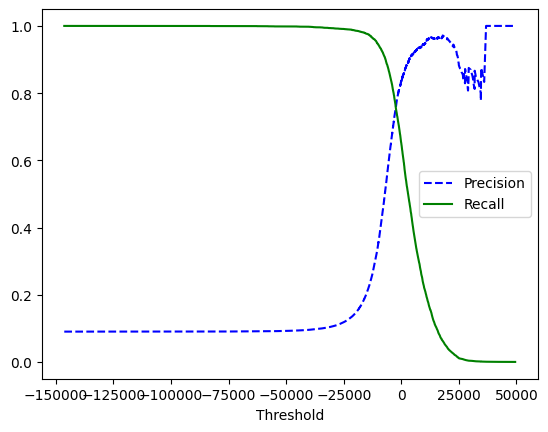

In [ ]:

# now we can plot on graph
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") # b-- means blue dashed lines in plot function
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")        # green solid line
    plt.xlabel("Threshold")
    plt.legend(loc="best")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [51]:
# Aiming for 90% precision by searching for using np.argmax()
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] 
y_train_pred_90 = (y_scores >= threshold_90_precision)


In [ ]:
# check percision and recall
precision_score(y_train_5, y_train_pred_90)
#90% precision

np.float64(0.9000345901072293)

In [54]:
recall_score(y_train_5, y_train_pred_90)


np.float64(0.4799852425751706)

In [56]:
# RECIVER OPERATING CHARACTERISTIC (ROC) curve
# It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)


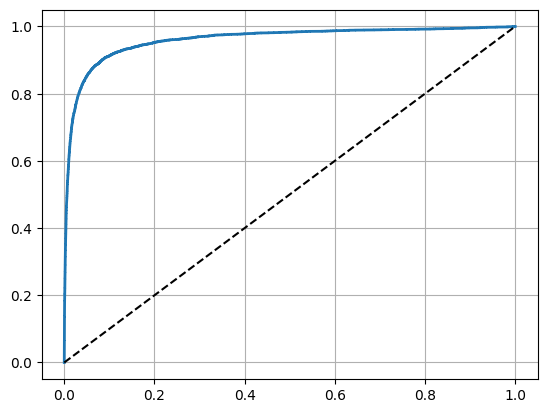

In [59]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.grid()
 
plot_roc_curve(fpr, tpr)
plt.show()

# the higher the recall (TPR), the more false positives (FPR) the classifier produces
# The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner)


In [60]:
# another way to compare classifiers is to measure AUC (area under curve)
# a perfect classifier will have ROC AUC = 1. Whereas a Purely Random will have a ROC = 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

# Training a `RandomForestClassifier` to Compare `ROC curve` and `ROC AUC score` to the `SGDClassifier`
- First we need to get scores for each instance in training set

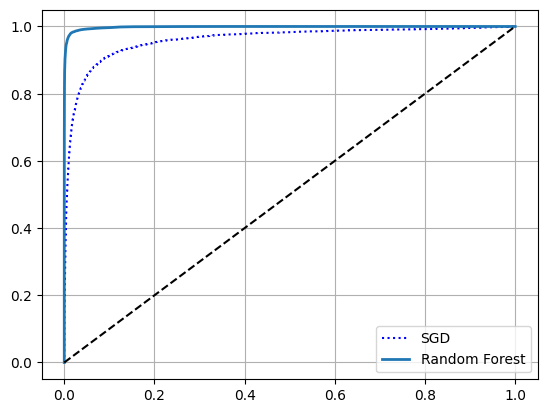

In [62]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

# to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the positive class’s probability as the score:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

# Now we plot the ROC curve:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()


In [63]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)